### Setting up Google Colab Environment

In [1]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [2]:
!kaggle datasets download -d sanjeetsinghnaik/used-car-information

Dataset URL: https://www.kaggle.com/datasets/sanjeetsinghnaik/used-car-information
License(s): CC0-1.0
  0% 0.00/176k [00:00<?, ?B/s]
100% 176k/176k [00:00<00:00, 371MB/s]


In [3]:
!unzip used-car-information.zip

Archive:  used-car-information.zip
  inflating: Dataset.csv             
  inflating: UsedCars_Banglore.csv   
  inflating: UsedCars_Chennai.csv    
  inflating: UsedCars_Combined.csv   
  inflating: UsedCars_Delhi.csv      
  inflating: UsedCars_Hyderabad.csv  
  inflating: UsedCars_Kolkata.csv    
  inflating: UsedCars_Mumbai.csv     
  inflating: UsedCars_Pune.csv       


### Reading the CSV

There are some columns which cannot be meaningfully used in linear regression. Those are columns that have unique text values (and nothing consistent can be extracted from them), or columns with unique identifier. Such columns will be removed from the dataset.

In [4]:
import pandas as pd

cars_df = pd.read_csv("Dataset.csv")
cars_df.describe()

,Unnamed: 0,Id,year,price,distance_travelled(kms),brand_rank,car_age,distance below 30k km,new and less used,inv_car_price,inv_car_dist,inv_car_age,inv_brand,std_invprice,std_invdistance_travelled,std_invrank,best_buy1,best_buy2
count,1725.000000,1725.000000,1725.000000,1.725000e+03,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1.725000e+03,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000
mean,862.000000,862.000000,2015.390725,1.494837e+06,53848.256232,15.731014,5.609275,0.269565,0.209275,1.416237e-06,0.000041,inf,0.187810,0.084623,0.013809,0.177658,88.962902,32.537208
std,498.108924,498.108924,3.207504,1.671658e+06,44725.541963,12.951122,3.207504,0.443863,0.406909,1.291449e-06,0.000110,NaN,0.254849,0.081060,0.038689,0.258034,188.950690,158.662274
min,0.000000,0.000000,1990.000000,6.250000e+04,350.000000,1.000000,0.000000,0.000000,0.000000,6.802721e-08,0.000001,0.032258,0.012346,0.000000,0.000000,0.000000,0.000000,0.000000
25%,431.000000,431.000000,2013.000000,5.450000e+05,29000.000000,5.000000,3.000000,0.000000,0.000000,5.479452e-07,0.000014,0.125000,0.041667,0.030123,0.004524,0.029687,14.237358,0.000000
50%,862.000000,862.000000,2016.000000,8.750000e+05,49000.000000,14.000000,5.000000,0.000000,0.000000,1.142857e-06,0.000020,0.200000,0.071429,0.067464,0.006703,0.059821,36.716166,0.000000
75%,1293.000000,1293.000000,2018.000000,1.825000e+06,70500.000000,24.000000,8.000000,1.000000,0.000000,1.834862e-06,0.000034,0.333333,0.200000,0.110899,0.011631,0.190000,90.776658,0.000000
max,1724.000000,1724.000000,2021.000000,1.470000e+07,790000.000000,81.000000,31.000000,1.000000,1.000000,1.600000e-05,0.002857,inf,1.000000,1.000000,1.000000,1.000000,2477.517640,2477.517640


### Removing unnecessary columns

`Id` is a unique identified for each value.

`full_model_name` consists of mostly unique value for each car. Meaningful features, like year of the car of brand name are already extracted in corresponding columns, so there is no point keeping it in context of linear regression.

Same for `model_name`

`std_invprice` and `inv_car_price` create a leakage of target column in the dataset, so they should be removed.

In [5]:
columns_to_remove = ["Id", "full_model_name", "model_name", "inv_car_price", "std_invprice"]

# There is an unnamed column so it should be removed by index

clean_df = cars_df.drop(cars_df.columns[0], axis=1).drop(columns=columns_to_remove)

clean_df.columns

Index(['year', 'brand', 'price', 'distance_travelled(kms)', 'fuel_type',
       'city', 'brand_rank', 'car_age', 'distance below 30k km',
       'new and less used', 'inv_car_dist', 'inv_car_age', 'inv_brand',
       'std_invdistance_travelled', 'std_invrank', 'best_buy1', 'best_buy2'],
      dtype='object')

First, I want to know how many different labels there are in the brand and city columns. If there are not too many, then we can use one-hot encoding.

*In retrospect, one-hot encoding is safe for linear regression, since most of the values would be 0, which mathematically reduces those columns and does not cause any "curse of dimensionality" problems.

** In next retrospect, one-hot encoding is not a good encoding for this dataset, since the amount of brands is quite large and the dataset does not contain enough rows for linear regression to find the correlation.

In [6]:
columns_to_count = ["brand", "city"]

for col in columns_to_count:
  print(clean_df[col].value_counts())
  print("\n")

brand
Hyundai             297
Maruti Suzuki       275
Honda               153
Mercedes-Benz       131
Toyota              117
BMW                 111
Audi                 98
Mahindra             93
Ford                 78
Volkswagen           70
Renault              51
Skoda                45
Tata                 44
Jaguar               30
Land Rover           28
Volvo                17
Nissan               13
Kia                  12
MINI                 10
Jeep                 10
MG                   10
Chevrolet             9
Porsche               5
Mitsubishi            4
Bentley               3
Datsun                3
Lamborghini           2
Lexus                 2
Fiat                  2
Isuzu                 1
Mahindra-Renault      1
Name: count, dtype: int64


city
Chennai        493
Bangalore      247
Pune           247
Hyderabad      245
Delhi          187
Mumbai         165
Dehradun        56
Thane           48
Noida           12
Ghaziabad       10
Lucknow          6
Navi Mum

### Categorical Brand Split

There are too many distinct brand values and too few dataset rows to use one-hot encoding. Because of that, I split brand column into three categories: economy, standard and premium.

It might look like splitting brands into subcategories creates data leakage of target column (price). However, that is not the case, since the split is done based on external domain knowledge, not on prices from the dataset itself, so it is fine.

In [7]:
economy_brands = [
    "Maruti Suzuki",
    "Hyundai",
    "Tata",
    "Mahindra",
    "Renault",
    "Ford",
    "Datsun",
    "Fiat",
    "Isuzu"
]

standard_brands = [
    "Honda",
    "Toyota",
    "Volkswagen",
    "Skoda",
    "Nissan",
    "Kia",
    "MG",
    "Chevrolet",
    "Mitsubishi"
]

premium_brands = [
    "BMW",
    "Mercedes-Benz",
    "Audi",
    "Jaguar",
    "Land Rover",
    "Volvo",
    "MINI",
    "Jeep",
    "Porsche",
    "Lexus",
    "Bentley",
    "Lamborghini",
    "Mahindra-Renault"
]


Now I will split these brands into three categories: economy, standard and premium.

Initially, I wanted to create a column for each brand. I got the following correlation results:

```
economy                     -0.390924
standard                    -0.170926
premium                      0.614698
```

However, after that I tried another approach, which yielded an overall better result (will explain my view of "better" in later section)

In [ ]:
clean_df["economy"] = clean_df["brand"].isin(economy_brands).astype(int)
clean_df["standard"] = clean_df["brand"].isin(standard_brands).astype(int)
clean_df["premium"] = clean_df["brand"].isin(premium_brands).astype(int)

In [ ]:
clean_df = clean_df.drop(columns=["economy", "standard", "premium"])

In [ ]:
columns_to_count = ["economy", "standard", "premium"]
for col in columns_to_count:
  print("Value counts:")
  print(clean_df[col].value_counts())
  print("\n")
  print("Percentage from total dataset:")
  print(clean_df[col].value_counts().filter(like="1", axis=0) / len(clean_df))
  print("\n")

I created another column `brand_tier`, which has values of:

- 1, if brand is economy
- 2, if brand is standard
- 3, if brand is premium

This column has a good correlation rate of 0.557198.

Having `brand_tier` column is better than having separate column for each brand category, since OneDimension is better than ThreeDimensions (OneDirection reference), and the previous `standard` and `economy` columns have a quite small correlation rate, even though `premium` column had a higher correlation rate than `brand_tier`.

I thought that correlation rate should also be considered in the context of weighted average of brand category distribution, meaning that I calculated the sum of correlations times their percentage of the dataset. In pseudocode, that would be
```
weighted_average = sum(correlation * (brand.count_of_ones / brand.total) for brand in brand_tier)
```

The weighted average was 0.393817376644. In retrospect, this value is actually meaningless. Of course, it is good for a column to have reasonable distribution of values (e.g. 1% of 0s and 99% of 1s), but if the column does not offer significant insight to the price, then the column has a smaller correlation value.

In [8]:
brand_tier_map = {
    **{b: 1 for b in economy_brands},
    **{b: 2 for b in standard_brands},
    **{b: 3 for b in premium_brands},
}

clean_df["brand_tier"] = clean_df["brand"].map(brand_tier_map)

Then, I tried creating a similar encoding for the cities based on population. Resulting `city_tier` column did not yield a good result on the same level as `brand_tier`, but it is still better than having it all in string values.

In [9]:
large_cities = [
    "Delhi",
    "Mumbai",
    "Bangalore",
    "Chennai",
    "Hyderabad",
    "Pune"
]

medium_cities = [
    "Noida",
    "Ghaziabad",
    "Thane",
    "Navi Mumbai",
    "Dehradun"
]

small_cities = [
    "Lucknow",
    "Faridabad",
    "Agra",
    "Panchkula"
]

In [10]:
city_tier_map = {
    **{c: 3 for c in large_cities},
    **{c: 2 for c in medium_cities},
    **{c: 1 for c in small_cities},
}

clean_df["city_tier"] = clean_df["city"].map(city_tier_map)


### Data Preprocessing

As a responsible data engineer, I will normalize and fix skewed data columns to get a better performance out of linear regression model. All columns are mapped onto [0, 1] range to provide better gradient descent performance.

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

categorical_columns = ["fuel_type"]
def encode_categorical(df):
  # One-hot encode categorical columns
  df = pd.get_dummies(df, columns=categorical_columns, drop_first=False, dtype=int)
  return df

dataset = encode_categorical(clean_df)

petrol_variants = [c for c in ("fuel_type_Petrol", "fuel_type_Petrol + 1") if c in dataset.columns]
if petrol_variants:
    dataset["fuel_type_Petrol"] = (dataset[petrol_variants].sum(axis=1) > 0).astype(int)

dataset = dataset.drop(
    columns=["fuel_type_Petrol + 1", "fuel_type_Diesel", "fuel_type_Hybrid", "fuel_type_CNG + 1"],
    errors="ignore",
)

dataset.describe()


,year,price,distance_travelled(kms),brand_rank,car_age,distance below 30k km,new and less used,inv_car_dist,inv_car_age,inv_brand,std_invdistance_travelled,std_invrank,best_buy1,best_buy2,brand_tier,city_tier,fuel_type_Petrol
count,1725.000000,1.725000e+03,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000
mean,2015.390725,1.494837e+06,53848.256232,15.731014,5.609275,0.269565,0.209275,0.000041,inf,0.187810,0.013809,0.177658,88.962902,32.537208,1.770435,2.912464,0.460290
std,3.207504,1.671658e+06,44725.541963,12.951122,3.207504,0.443863,0.406909,0.000110,NaN,0.254849,0.038689,0.258034,188.950690,158.662274,0.834679,0.302524,0.498565
min,1990.000000,6.250000e+04,350.000000,1.000000,0.000000,0.000000,0.000000,0.000001,0.032258,0.012346,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,2013.000000,5.450000e+05,29000.000000,5.000000,3.000000,0.000000,0.000000,0.000014,0.125000,0.041667,0.004524,0.029687,14.237358,0.000000,1.000000,3.000000,0.000000
50%,2016.000000,8.750000e+05,49000.000000,14.000000,5.000000,0.000000,0.000000,0.000020,0.200000,0.071429,0.006703,0.059821,36.716166,0.000000,2.000000,3.000000,0.000000
75%,2018.000000,1.825000e+06,70500.000000,24.000000,8.000000,1.000000,0.000000,0.000034,0.333333,0.200000,0.011631,0.190000,90.776658,0.000000,3.000000,3.000000,1.000000
max,2021.000000,1.470000e+07,790000.000000,81.000000,31.000000,1.000000,1.000000,0.002857,inf,1.000000,1.000000,1.000000,2477.517640,2477.517640,3.000000,3.000000,1.000000


### Correlation Heatmap

I made a correlation heatmap to see how columns pairwise correlate to each other. Obviously, the main diagonal has full correlation and inverse values are the opposite of the original values. I also print to the console the correlations specifically to the `price` column.

Correlation of dataset columns to price:
year                         0.288483
price                        1.000000
distance_travelled(kms)     -0.137351
brand_rank                  -0.164591
car_age                     -0.288483
distance below 30k km        0.212197
new and less used            0.219786
inv_car_dist                 0.081735
inv_car_age                  0.267973
inv_brand                    0.185660
std_invdistance_travelled    0.081735
std_invrank                  0.185660
best_buy1                   -0.106855
best_buy2                    0.008077
brand_tier                   0.557198
city_tier                   -0.112516
fuel_type_Petrol            -0.263987
Name: price, dtype: float64


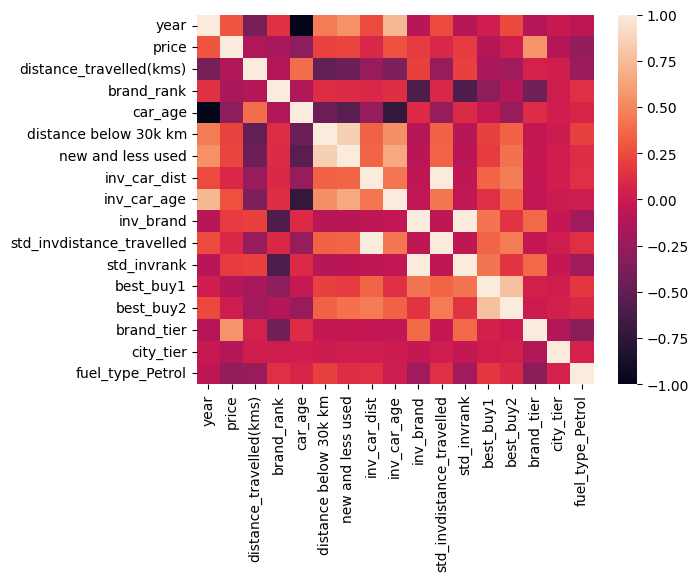

In [14]:
import seaborn

corr = dataset.corr(numeric_only=True)
seaborn.heatmap(corr)

print("Correlation of dataset columns to price:")
print(corr["price"])

### Variance Inflation Factor (VIF) Analysis

Below I analyzed the Variance Inflation Factor (VIF) between several columns. After analyzing the results, it looks like some columns have very high VIFs relative to other ones.

For example, diesel and petrol cars seem to be highly correlated to the year. Even though no research suggests that, high VIFs means that the columns are highly related, hence these columns have to be PCAed or combined to avoid multicollinearity.

Usually, high VIF columns add noise to the dataset and degrade the performance of linear regression models. However, in my case, leaving these `fuel_type` columns improved the performance of the models.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Inverse columns will show a infinite variation, since they are directly
# correlated to the original columns
inv_columns = [col for col in dataset.columns if col.startswith('inv_')]
# X = dataset.copy().drop(columns=["brand", "city", "car_age"] + inv_columns)
X = dataset[[col for col in dataset.columns if col.startswith('fuel_')] + ["year"]]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

/tmp/ipython-input-1209833172.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


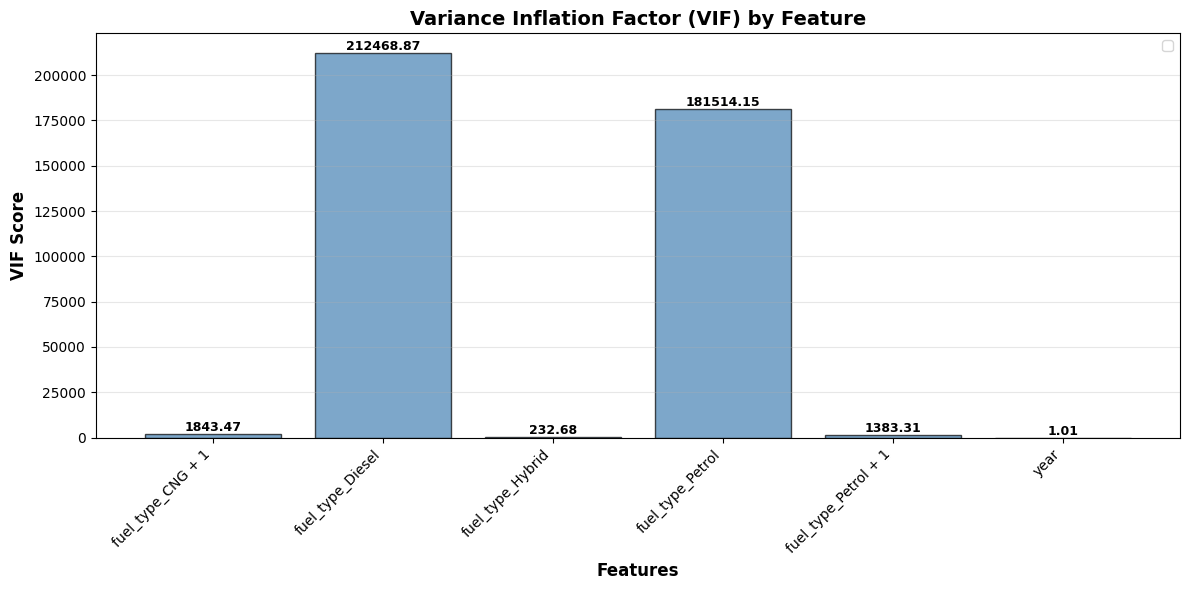

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Replace inf values with a large number for visualization
vif_clean = [v if not np.isinf(v) else np.nan for v in vif]
max_finite = max([v for v in vif_clean if not np.isnan(v)]) if any(not np.isnan(v) for v in vif_clean) else 100

# Replace NaN (previously inf) with max_finite * 1.2 for visual distinction
vif_plot = [v if not np.isnan(v) else max_finite * 1.2 for v in vif_clean]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(range(len(vif_plot)), vif_plot, color='steelblue', edgecolor='black', alpha=0.7)

# Color bars with inf values differently
for i, (v_orig, bar) in enumerate(zip(vif, bars)):
    if np.isinf(v_orig):
        bar.set_color('red')
        bar.set_alpha(0.5)

# Add column names as x-axis labels
ax.set_xticks(range(len(X.columns)))
ax.set_xticklabels(X.columns, rotation=45, ha='right')

# Add value labels on top of each bar
for i, (bar, v_orig) in enumerate(zip(bars, vif)):
    height = bar.get_height()
    label = 'inf' if np.isinf(v_orig) else f'{v_orig:.2f}'
    ax.text(bar.get_x() + bar.get_width()/2., height,
            label, ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Features', fontsize=12, fontweight='bold')
ax.set_ylabel('VIF Score', fontsize=12, fontweight='bold')
ax.set_title('Variance Inflation Factor (VIF) by Feature', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Correlation Analysis

I calculate the average of different correlation methods to have a stable correlation value of each column.

In [15]:
corr_methods = ["pearson", "kendall", "spearman"]
ignore_columns = []

corr_list = []

def describe_correlation(col: pd.Series):
  acc = 0
  temp_df = pd.DataFrame(col).drop(columns=ignore_columns).join(dataset["price"])
  print(temp_df.describe())
  for corr_method in corr_methods:
    corr_matrix = temp_df.corr(method=corr_method)
    corr = corr_matrix.iloc[0, 1]
    print(f"{corr_method}: {prec(corr)}")
    acc += corr

  avg = acc / len(corr_methods)
  print(f"avg: {prec(avg)}")
  print("\n")

  corr_list.append((col.name, avg))

In [16]:
ignore_cols = ["brand", "price", "petrol", "city"]
precision = 4

def prec(n, p=precision):
  return f"{n:.{p}f}"

for column in dataset.columns:
  if column in ignore_cols:
    # do nothing
    pass
  else:
    print(f"{column}")
    describe_correlation(dataset[column])

year
              year         price
count  1725.000000  1.725000e+03
mean   2015.390725  1.494837e+06
std       3.207504  1.671658e+06
min    1990.000000  6.250000e+04
25%    2013.000000  5.450000e+05
50%    2016.000000  8.750000e+05
75%    2018.000000  1.825000e+06
max    2021.000000  1.470000e+07
pearson: 0.2885
kendall: 0.3331
spearman: 0.4483
avg: 0.3566


distance_travelled(kms)
       distance_travelled(kms)         price
count              1725.000000  1.725000e+03
mean              53848.256232  1.494837e+06
std               44725.541963  1.671658e+06
min                 350.000000  6.250000e+04
25%               29000.000000  5.450000e+05
50%               49000.000000  8.750000e+05
75%               70500.000000  1.825000e+06
max              790000.000000  1.470000e+07
pearson: -0.1374
kendall: -0.1279
spearman: -0.1920
avg: -0.1524


brand_rank
        brand_rank         price
count  1725.000000  1.725000e+03
mean     15.731014  1.494837e+06
std      12.951122  1.671658e

### Performing Correlation Analysis

Below I use three main correlation methods from Pandas library to see how proportional the values from each column is to car prices.

For final comparison, I decided to average out the value of each correlation method to get a single number for each column. This can be done, since the values of each correlation method are quite close to each other and do not cancel out each other.

`brand_tier` (`brand_rank`) and `year` (`car_age`) values are, obviously, highly correlated to the price. A car having diesel or petrol engine also is an important factor when predicting the price. The distance travelled and state of the car (`new and less used`) are also correlated to the price.

City and less popular fuel types, in the context of this dataset, are not reflecting well on the car price.

In [17]:
sorted_corr = sorted(corr_list, key=lambda tup: abs(tup[1]), reverse=True)

print("Most correlated features (by absolute value):")
for col, num in sorted_corr:
  print(f"{col}: {num}")

Most correlated features (by absolute value):
brand_tier: 0.5351494694529131
fuel_type_Petrol: -0.3604954703705258
year: 0.35662398572079473
car_age: -0.3566239857207889
inv_car_age: 0.34694950102325256
new and less used: 0.23551721525961936
std_invrank: 0.22656696814679625
inv_brand: 0.22656696814679614
brand_rank: -0.2195438256408183
best_buy1: -0.1991036681551053
distance below 30k km: 0.19192736263739482
distance_travelled(kms): -0.15241021929958692
best_buy2: 0.1422997164164845
std_invdistance_travelled: 0.13387133626567604
inv_car_dist: 0.1338713362656746
city_tier: -0.08703707443762942


### Selecting Columns for Training

I dropped inverse columns, since they had a smaller correlation to the price and their values are already reflected in the original columns. Then, I filtered the columns which have correlation larger than a certain threshold (I ultimately chose the value of 1) to only train the model on important columns to avoid noise.

In [19]:
drop_cols = ["inv_car_age", "inv_brand", "inv_car_dist", "car_age",
             "distance below 30k km", "std_invdistance_travelled",
             "std_invrank", "best_buy1", "best_buy2"]
threshold = 0.1

training_cols = [col for col, num in sorted_corr if abs(num) > threshold and not col in drop_cols]
training_cols

['brand_tier',
 'fuel_type_Petrol',
 'year',
 'new and less used',
 'brand_rank',
 'distance_travelled(kms)']

### Splitting into Test / Train Dataset

In [20]:
from sklearn.preprocessing import StandardScaler

num_cols = ["price", "distance_travelled(kms)", "brand_rank", "car_age", "year",
  'new and less used', 'inv_car_dist', 'inv_car_age', 'inv_brand', 'brand_tier',
  "best_buy1", "best_buy2", "year", "brand_mean_price"]

def preprocess_df(X, y, drop_cols):
    X = X.copy()
    y = y.values.reshape(-1, 1)

    num_cols_relevant = [
        col for col in num_cols
        if col not in drop_cols and col in X.columns
    ]
    scaler_X = StandardScaler()
    X[num_cols_relevant] = scaler_X.fit_transform(X[num_cols_relevant])

    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y).ravel()

    return X, y_scaled, scaler_X, scaler_y

Applying the training scaler transformations to test set, but without scaler fitting.

In [21]:
from sklearn.model_selection import train_test_split

X = dataset[training_cols]
y = dataset['price']

train_idx, test_idx = train_test_split(
    clean_df.index, test_size=0.2, random_state=42, shuffle=True
)

X_train = dataset.loc[train_idx, training_cols].copy()
X_test  = dataset.loc[test_idx, training_cols].copy()
y_train = dataset.loc[train_idx, "price"]
y_test  = dataset.loc[test_idx, "price"]

brand_mean_price = (
    clean_df.loc[train_idx]
    .groupby("brand")["price"]
    .mean()
)

X_train["brand_mean_price"] = clean_df.loc[train_idx, "brand"].map(brand_mean_price)
X_test["brand_mean_price"] = clean_df.loc[test_idx, "brand"].map(brand_mean_price)

# If a brand appears only in test, fall back to the overall train mean
fallback = float(y_train.mean())
X_train["brand_mean_price"] = X_train["brand_mean_price"].fillna(fallback)
X_test["brand_mean_price"] = X_test["brand_mean_price"].fillna(fallback)
X_train_proc, y_train_proc, scaler_X, scaler_y = preprocess_df(
    X_train, y_train, drop_cols=drop_cols
)

X_test_proc = X_test.copy()

num_cols_relevant = [
    col for col in num_cols
    if col not in drop_cols and col in X_test_proc.columns
]

X_test_proc[num_cols_relevant] = scaler_X.transform(
    X_test_proc[num_cols_relevant]
)

y_test_scaled = scaler_y.transform(
    y_test.values.reshape(-1, 1)
).ravel()

print(X_train_proc.describe())

         brand_tier  fuel_type_Petrol          year  new and less used  \
count  1.380000e+03       1380.000000  1.380000e+03       1.380000e+03   
mean  -3.089316e-17          0.463768  1.438592e-14       3.346759e-17   
std    1.000363e+00          0.498866  1.000363e+00       1.000363e+00   
min   -9.099574e-01          0.000000 -7.780121e+00      -4.988675e-01   
25%   -9.099574e-01          0.000000 -7.137603e-01      -4.988675e-01   
50%    2.917088e-01          0.000000  2.079389e-01      -4.988675e-01   
75%    1.493375e+00          1.000000  8.224051e-01      -4.988675e-01   
max    1.493375e+00          1.000000  1.744104e+00       2.004540e+00   

         brand_rank  distance_travelled(kms)  brand_mean_price  
count  1.380000e+03             1.380000e+03      1.380000e+03  
mean   6.371715e-17             1.802101e-17      5.148860e-17  
std    1.000363e+00             1.000363e+00      1.000363e+00  
min   -1.140382e+00            -1.146209e+00     -1.070880e+00  
25%   -9

In [ ]:
print(X_test_proc.describe())

       brand_tier  fuel_type_Diesel        year  fuel_type_Petrol  \
count  345.000000        345.000000  345.000000        345.000000   
mean     0.079240          0.040655    0.103747         -0.040705   
std      1.012489          0.998136    0.920108          0.997415   
min     -0.909957         -1.062840   -3.478858         -0.924575   
25%     -0.909957         -1.062840   -0.406527         -0.924575   
50%      0.291709          0.940875    0.207939         -0.924575   
75%      1.493375          0.940875    0.822405          1.081578   
max      1.493375          0.940875    1.744104          1.081578   

       new and less used  brand_rank  distance_travelled(kms)  
count         345.000000  345.000000               345.000000  
mean            0.125170    0.026714                -0.115968  
std             1.084531    1.035750                 0.628603  
min            -0.498867   -1.140382                -1.143271  
25%            -0.498867   -0.673724                -0.607

### SciKitLearn Linear Regression

I train the model using Linear Regression model provided by the sklearn library

In [22]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_proc, y_train_proc)


LinearRegression()

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred_scaled = lr.predict(X_test_proc)

y_pred = scaler_y.inverse_transform(
    y_pred_scaled.reshape(-1, 1)
).ravel()

y_true = scaler_y.inverse_transform(
    y_test_scaled.reshape(-1, 1)
).ravel()

print(list(zip(y_pred, y_true))[:10])

print(f"MSE: {mean_squared_error(y_true, y_pred)}")
print(f"MAE: {mean_absolute_error(y_true, y_pred)}")
print(f"R^2: {r2_score(y_true, y_pred)}")

[(np.float64(451642.7755401586), np.float64(365000.0)), (np.float64(1402236.484241035), np.float64(1195000.0)), (np.float64(1124527.4921476315), np.float64(575000.0)), (np.float64(1177574.0223971808), np.float64(900000.0)), (np.float64(1547706.7750258052), np.float64(1675000.0)), (np.float64(1685597.1608003778), np.float64(1050000.0)), (np.float64(1114361.2956784149), np.float64(675000.0)), (np.float64(4117216.7795218863), np.float64(2600000.0)), (np.float64(2886988.5939800926), np.float64(2400000.0)), (np.float64(1827158.3802535003), np.float64(990000.0))]
MSE: 1587974933644.7363
MAE: 662580.318823414
R^2: 0.5269680191639448


### Sigmoid's Linear Regression Implementation

I train the model using Linear Regression model provided by Sigmoid Handbook.

In [24]:
import numpy as np
import math

class SigmoidLinearRegression():
    """
    Initializes the Linear Regression model.
    It stores the self.params__ variable, which will be the
    weights that the model returns.
    """
    def __init__(self):
        self.params__ = None

    def gradientDescent(self, X, y, learning_rate=0.00001, iterations=500, batch_size=16):
        """
        This function applies the Stochastic Gradient Descent model to the dataset.

        :param X: numpy.ndarray - The matrix containing independent variable columns.
        :param y: numpy.ndarray - The target vector y.
        """
        # Add a column of ones for the constant term (bias)
        # We ensure y is reshaped to (rows, 1) to match X's dimensions
        if len(y.shape) == 1:
            y = y.reshape(-1, 1)

        X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
        rows, cols = X.shape

        # Combine X and y to shuffle them together
        data = np.concatenate([X, y], axis=1)

        # Initial random guess for weights (w)
        w = np.random.random((cols, 1))

        for i in range(iterations):
            # Shuffle the rows of the data at the start of each iteration
            np.random.shuffle(data)

            y_it = data[:, -1].reshape((rows, 1))
            X_it = data[:, :-1]

            # Iterate through the batches
            for batch in range(math.ceil(rows / batch_size)):
                batch_start = batch * batch_size
                batch_end = min(batch_start + batch_size, rows)

                x_batch = X_it[batch_start:batch_end]
                y_batch = y_it[batch_start:batch_end]

                # Calculate the error (predictions - actual)
                prediction_error = np.matmul(x_batch, w) - y_batch

                # Update weights: w = w - learning_rate * (X_transpose * error)
                # Note: Dividing by batch size helps stabilize the learning rate
                gradient = np.matmul(x_batch.T, prediction_error)
                w -= learning_rate * gradient

        self.params__ = w
        return self

    def predict(self, X):
        """
        Predicts target values for the given input features.
        """
        # Add the column of ones for the constant term (bias)
        bias_column = np.ones((X.shape[0], 1))
        X = np.concatenate([X, bias_column], axis=1)

        return np.matmul(X, self.params__)

In [36]:
slr = SigmoidLinearRegression()

mask_train = np.isfinite(y_train.to_numpy())
mask_train &= np.isfinite(X_train.to_numpy()).all(axis=1)

X_train_clean = X_train.loc[mask_train].copy()
y_train_clean = y_train.loc[mask_train].copy()

slr.gradientDescent(X_train_clean.to_numpy(), y_train_clean.to_numpy(), learning_rate=0.015)

/tmp/ipython-input-1591207387.py:54: RuntimeWarning: overflow encountered in matmul
  gradient = np.matmul(x_batch.T, prediction_error)
/tmp/ipython-input-1591207387.py:50: RuntimeWarning: overflow encountered in matmul
  prediction_error = np.matmul(x_batch, w) - y_batch
/tmp/ipython-input-1591207387.py:54: RuntimeWarning: invalid value encountered in matmul
  gradient = np.matmul(x_batch.T, prediction_error)
/tmp/ipython-input-1591207387.py:55: RuntimeWarning: invalid value encountered in subtract
  w -= learning_rate * gradient


In [39]:
y_pred = slr.predict(X_test.to_numpy())

mask = np.isfinite(y_true) & np.isfinite(y_pred)
y_true_clean = y_true[mask]
y_pred_clean = y_pred[mask]

print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"R^2: {r2_score(y_test, y_pred)}")

MSE: 1587974933644.7363
MAE: 662580.318823414
R^2: 0.5269680191639448


### Final Results

Accuracy achieved from sklearn model and from Sigmoid model is almost the same. The fact that sklearn's model has a slighly better `R^2` accuracy is probably caused by learning rate optimization, for example by using learning rate decay.

MAE is about 6%, which is quite good, considering the low correlation level of the columns (not in the range of 0.5-0.8 required by the handbook).

`R^2` score indicates that the columns are decent at predicting the price, and that there is indeed some correlation between independent columns and the dependent one.

The accuracy of the model could be improved by engineering additional features based on the existing ones (e.g. economical index of the city, based on population, average income and other factors). Also, it is reasonable to assume that some columns that the model were trained on have introduced noise to the dataset and their exclusion from the training process could improve the model performance.

### Actual vs Predicted Price

In [27]:
import matplotlib.pyplot as plt


def plot_actual_vs_predicted(model, y_true, y_pred, X=None):
    """
    Plot actual vs predicted values for a linear regression model.

    Parameters:
    -----------
    model : sklearn LinearRegression
        Trained linear regression model
    y_true : array-like
        Actual target values (raveled)
    y_pred : array-like
        Predicted target values (raveled)
    X : array-like, optional
        Feature values. If provided and 1D, will be used for x-axis.
        If not provided, uses indices.
    """
    plt.figure(figsize=(10, 6))

    # Determine x-axis values
    if X is not None:
        if X.ndim > 1 and X.shape[1] == 1:
            x_vals = X.ravel()
        elif X.ndim == 1:
            x_vals = X
        else:
            # For multivariate, use indices
            x_vals = np.arange(len(y_true))
            print("Note: Using indices for x-axis (multivariate case)")
    else:
        x_vals = np.arange(len(y_true))

    # Sort by y_true (actual price) in ascending order
    sort_idx = np.argsort(y_true)
    x_vals_sorted = x_vals[sort_idx]
    y_true_sorted = y_true[sort_idx]
    y_pred_sorted = y_pred[sort_idx]

    # Use sorted index as x-axis to show progression by price
    x_axis = np.arange(len(y_true_sorted))

    # Plot actual values as scatter points
    plt.scatter(x_axis, y_true_sorted, alpha=0.6, s=50, label='Actual values',
                color='blue', edgecolors='black', linewidth=0.5)

    # Plot predictions for each data point
    plt.scatter(x_axis, y_pred_sorted, alpha=0.6, s=50, label='Predicted values',
                color='red', marker='x', linewidth=2)

    # Plot regression line using model coefficients
    # Create a smooth line across the range of x values
    x_line = np.linspace(x_axis.min(), x_axis.max(), 100)

    if X is not None and (X.ndim == 1 or X.shape[1] == 1):
        # For univariate case, interpolate along sorted actual prices
        y_line = np.interp(x_line, x_axis, y_pred_sorted)
    else:
        # For multivariate or no X provided, use predicted values
        y_line = np.interp(x_line, x_axis, y_pred_sorted)


    plt.xlabel('Data Points (sorted by actual price)')
    plt.ylabel('Price')
    plt.title('Actual vs Predicted Values (Sorted by Actual Price)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    return plt

Note: Using indices for x-axis (multivariate case)


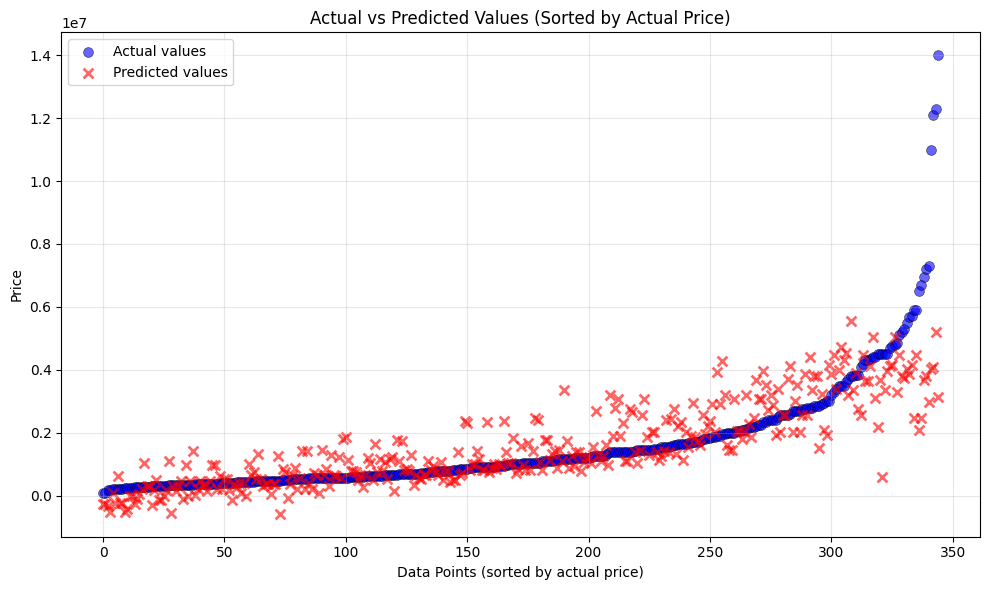

In [30]:
plot_actual_vs_predicted(lr, y_true, y_pred, X_test_proc)
plt.show()